In [1]:
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/handwritingBCIData/'

#point this towards the code directory
repoDir = os.getcwd() + '/'

#defines which train/test partition to use
cvPart = 'HeldOutTrials'

#defines which datasets to process
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']


In [2]:
#First we have to convert the LSTM outputs to a format that Kaldi can read. Here we make a Kaldi-readable matrix
#for each sentence that contains the LSTM outputs. 
from characterDefinitions import getHandwritingCharacterDefinitions
from LSTMEval import lstmOutputToKaldiMatrices

charDef = getHandwritingCharacterDefinitions()
allErrCounts = []
outDir = rootDir+'LSTMTrainingSteps/Step5_LSTMInference/' + cvPart

for x in range(len(dataDirs)):
    print(dataDirs[x])
    
    outputs = scipy.io.loadmat(outDir + '/' + dataDirs[x] + '_inferenceOutputs.mat')
    sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDirs[x]+'/sentences.mat')
    
    #define where to save the Kaldi matrices
    kaldiDir = rootDir+'LSTMTrainingSteps/Step6_ApplyBigramLM/' + cvPart + '/KaldiMatrices/' + dataDirs[x] + '/'
    if not os.path.isdir(kaldiDir):
        os.mkdir(kaldiDir)

    #This function converts the LSTM output to kaldi matrices so the language model can process it.
    #Note that as part of this process we use the LSTM's character start signal output to create a fake 'CTC blank' signal
    #for the language model (the language model was originally designed to be used with a CTC loss).
    cProb = lstmOutputToKaldiMatrices(outputs['outputs'], 
                             sentenceDat['numTimeBinsPerSentence']/2+50, 
                             charDef, 
                             kaldiDir)
    

t5.2019.05.08
t5.2019.11.25
t5.2019.12.09
t5.2019.12.11
t5.2019.12.18
t5.2019.12.20
t5.2020.01.06
t5.2020.01.08
t5.2020.01.13
t5.2020.01.15


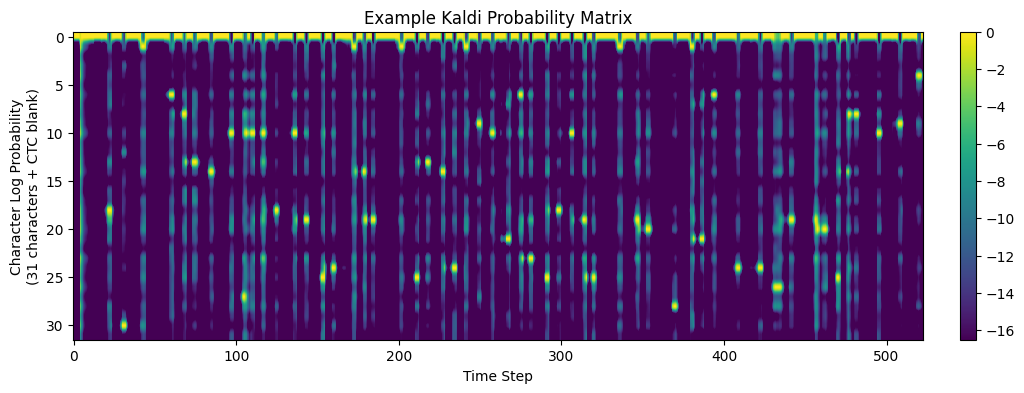

In [3]:
#Visualize what a Kaldi matrix looks like. Note that the first row is the CTC-blank signal, which goes low only briefly whenever
#there is a new character.
plt.figure(figsize=(12,4))
plt.imshow(cProb[122].T, aspect='auto', clim=[0,-15])
plt.xlabel('Time Step')
plt.ylabel('Character Log Probability\n(31 characters + CTC blank)')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Example Kaldi Probability Matrix')
plt.show()

In [4]:
#Now call kaldi to apply the language model to the probability matrices created above.
#Note that you will need kaldi (https://github.com/kaldi-asr/kaldi) 
#AND you will need custom kaldi decoders from https://github.com/jpuigcerver/kaldi-decoders.
from parallelBash import parallelBash
import time
import multiprocessing

#Add kaldi and kaldi-decoders binaries to the path. This assumes that kaldi is located in the home directory.
homeDir = os.path.expanduser('~/')
os.environ['PATH'] += ':'+homeDir+'kaldi-decoders/bin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/bin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/lm'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/lmbin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/fstbin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/featbin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/gmmbin'
os.environ['PATH'] += ':'+homeDir+'kaldi/tools/openfst-1.6.7/bin'
os.environ['PATH'] += ':'+homeDir+'kaldi/src/latbin'

#make sure we have permission to execute all the scripts we'll be calling below
os.system('chmod +x ' + repoDir+'kaldiLMScripts/bigramLmDecode.sh')
os.system('chmod +x ' + repoDir+'kaldiLMScripts/parseOptions.inc.sh')
os.system('chmod +x ' + repoDir+'kaldiLMScripts/remove_transcript_dummy_boundaries.sh')
os.system('chmod +x ' + repoDir+'kaldiLMScripts/int2sym.pl')

#for each dataset, we launch multiple instances of the kaldi decoder program in parallel, each operating on a single sentence
for dataDir in dataDirs:
    print(dataDir)

    #where the language model files are stored
    langModelDir = rootDir+'BigramLM'
    
    #where the kaldi probability matrices are saved (these are inputs for this step)
    matsDir = rootDir+'LSTMTrainingSteps/Step6_ApplyBigramLM/'+cvPart+'/KaldiMatrices/'+dataDir
    
    #where we should save the language model outputs (which are lists of candidate sentences, along with their scores)
    outDir = rootDir+'LSTMTrainingSteps/Step6_ApplyBigramLM/'+cvPart+'/KaldiOutput/'+dataDir
    if not os.path.isdir(outDir):
        os.mkdir(outDir)
        
    #clear previous LM outputs
    os.system('rm ' + outDir + '/*')

    #This next bit of code generates some temporary .sh files that help launch multiple decoding programs at once.
    #we then launch the '_master.sh' file to kick everything off, and wait until the outputs are all there before continuing
    #to the next dataset.
    scriptFile = repoDir + 'kaldiLMScripts/bigramLmDecode.sh'
    
    if not os.path.isdir(rootDir + 'LSTMTrainingSteps/bashScratch'):
        os.mkdir(rootDir + 'LSTMTrainingSteps/bashScratch')
    bashFilePrefix = rootDir + 'LSTMTrainingSteps/bashScratch/lmDecode'
    
    fileList = os.listdir(matsDir)
    txtFiles = []
    for f in fileList:
        if f.endswith('.txt'):
            txtFiles.append(f)
            
    nFiles = len(txtFiles)    
    nParallelProcesses = int(multiprocessing.cpu_count()/2)

    sentenceIdx = np.arange(0,nFiles).astype(np.int32)
    
    argList = []
    for x in range(len(sentenceIdx)):
        newArgs = {}
        newArgs['acoustic_scale'] = 1.0 #1.0, 1.79
        newArgs['beam'] = 65
        newArgs['max_active'] = 5000 #500000 #5000000
        newArgs['1_mainArg'] = langModelDir
        newArgs['2_mainArg'] = matsDir + '/kaldiMat_'+str(sentenceIdx[x])+'.txt'
        newArgs['3_mainArg'] = outDir + '/' + str(sentenceIdx[x]) + '_'

        argList.append(newArgs)

    #this utility function generates temporary .sh files for running parallel decoding
    parallelBash(argList, scriptFile, bashFilePrefix, nParallelProcesses)
        
    #make sure we have permissions to execute everything
    os.system('chmod +x ' + bashFilePrefix+'_master.sh')
    for x in range(nParallelProcesses):
        os.system('chmod +x ' + bashFilePrefix+'_'+str(x)+'.sh')
            
    #launching the master file starts everything
    os.system(bashFilePrefix+'_master.sh')

    #now we just sit and wait until we have all the outputs
    numFilesInDir = 0
    while numFilesInDir < nFiles*9:
        numFilesInDir = int(len(os.listdir(outDir)))
        time.sleep(1)
        

chmod: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
chmod: semestre/Machine: No such file or directory
chmod: Learning/Progetto: No such file or directory
chmod: /BCI/BCI_HW/kaldiLMScripts/bigramLmDecode.sh: No such file or directory
chmod: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
chmod: semestre/Machine: No such file or directory
chmod: Learning/Progetto: No such file or directory
chmod: /BCI/BCI_HW/kaldiLMScripts/parseOptions.inc.sh: No such file or directory
chmod: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
chmod: semestre/Machine: No such file or directory
chmod: Learning/Progetto: No such file or directory
chmod: /BCI/BCI_HW/kaldiLMScripts/remove_transcript_dummy_boundaries.sh: No such file or directory
chmod: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
chmod: semestre/Machine: No such

t5.2019.05.08


/Users/bishoyzakhary/handwritingBCIData/LSTMTrainingSteps/bashScratch/lmDecode_0.sh: line 1: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
/Users/bishoyzakhary/handwritingBCIData/LSTMTrainingSteps/bashScratch/lmDecode_2.sh: line 1: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
/Users/bishoyzakhary/handwritingBCIData/LSTMTrainingSteps/bashScratch/lmDecode_1.sh: line 1: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
/Users/bishoyzakhary/handwritingBCIData/LSTMTrainingSteps/bashScratch/lmDecode_0.sh: line 2: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
/Users/bishoyzakhary/handwritingBCIData/LSTMTrainingSteps/bashScratch/lmDecode_2.sh: line 2: /Users/bishoyzakhary/Desktop/università/Magisitrale/2023:2024/II: No such file or directory
/Users/bishoyzakhary/handwritingBCIData/LSTMTrainingSteps/bashScratch/

In [ ]:
#Now that we have all the language model outputs, load them up and compute character/word error rates
from kaldiReadWrite import readKaldiLatticeFile, readKaldiAliFile
import numpy as np
import scipy.io
from LSTMEval import wer
import warnings

#this stops scipy.io.savemat from throwing a warning about empty entries
warnings.simplefilter(action='ignore', category=FutureWarning)

#keep track of the error counts for all validation sentences in 'valErrCounts' so we can summarize in the next cell
valErrCounts = []

for dataDir in dataDirs:
    #process ALL sentences from this dataset (both train & test)
    print(' --' + dataDir + '-- ')

    sentenceDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/sentences.mat')
    cvPartFile = scipy.io.loadmat(rootDir+'LSTMTrainingSteps/trainTestPartitions_'+cvPart+'.mat')
    valIdx = cvPartFile[dataDir+'_test']
    
    allErrCounts = []
    decSentences = []
    
    kaldiDir = rootDir+'LSTMTrainingSteps/Step6_ApplyBigramLM/'+cvPart+'/KaldiOutput/'+dataDir 
    nFiles = int(len(os.listdir(kaldiDir))/9)   
    
    for fileIdx in range(nFiles):
        nbestFile = kaldiDir+'/'+str(fileIdx)+'_transcript.txt'
        acFile = kaldiDir+'/'+str(fileIdx)+'_best_acscore.ark'
        lmFile = kaldiDir+'/'+str(fileIdx)+'_best_lmscore.ark'

        nums, content = readKaldiLatticeFile(nbestFile, 'string')
        _, acScore = readKaldiLatticeFile(acFile, 'numeric')
        _, lmScore = readKaldiLatticeFile(lmFile, 'numeric')

        #here we select the best-scoring sentence according to the formula 'acScore + 2.0*lmScore'
        bestIdx = np.argmin(acScore + 2.0*lmScore)
        decSent = content[bestIdx]
        decSentences.append(decSent)
        
        trueText = sentenceDat['sentencePrompt'][fileIdx,0][0]
        trueText = trueText.replace('>',' ')
        trueText = trueText.replace('~','.')
        trueText = trueText.replace('#','')
        
        #compute character/word error counts
        charErrs = wer(trueText, decSent)
        wordErrs = wer(trueText.split(), decSent.split())
        allErrCounts.append(np.array([charErrs, len(trueText), wordErrs, len(trueText.split())]))

        #print the language model outputs for all sentences in the held-out set
        if fileIdx in valIdx:
            print('#' + str(fileIdx))
            print('True:    ' + trueText)
            print('Decoded: ' + decSent)
            print('')
            
            valErrCounts.append(np.array([charErrs, len(trueText), wordErrs, len(trueText.split())]))

    #save error rates & decoded sentences for this dataset
    concatCounts = np.stack(allErrCounts, axis=0)

    saveDict = {}
    saveDict['decSentences'] = decSentences
    saveDict['trueSentences'] = sentenceDat['sentencePrompt']
    saveDict['charCounts'] = concatCounts[:,1]
    saveDict['charErrors'] = concatCounts[:,0]
    saveDict['wordCounts'] = concatCounts[:,3]
    saveDict['wordErrors'] = concatCounts[:,2]

    scipy.io.savemat(rootDir + 'LSTMTrainingSteps/Step6_ApplyBigramLM/' + cvPart + '/' + dataDir + '_errCounts.mat', saveDict)

    

In [ ]:
#Summarize character error rate and word error rate across all held-out trials from all datasets
concatErrCounts = np.squeeze(np.stack(valErrCounts, axis=0))
cer = 100*(np.sum(concatErrCounts[:,0]) / np.sum(concatErrCounts[:,1]))
wer = 100*(np.sum(concatErrCounts[:,2]) / np.sum(concatErrCounts[:,3]))

print('Character error rate: %1.2f%%' % float(cer))
print('Word error rate: %1.2f%%' % float(wer))